# Introduction

Image-to-image translation is a fundamental task in computer vision that focuses on converting an image from one domain into a corresponding image in another. This project explores the use of **Cycle-Consistent Generative Adversarial Networks (CycleGANs)** for translating images between two visually distinct animals: cats and dogs. This tasks is more difficult than translating between two similar animals due to the differences in shape, texture, facial structure, fur patterns and other distinct features between cats and dogs. Unlike traditional methods requiring paired datasets, where an image of a cat is directly matched with an equivalent image of a dog, CycleGANs enable unpaired image-to-image translation, making them a great fit for this project.

The primary objective is to develop a model capable of transforming an image of a cat into an image of a dog, and vice versa, while preserving important attributes such as pose, orientation, and background context. Achieving this requires not only generating realistic textures and colors but also ensuring structural consistency between the input and output images.

For this project, I will utilize the **Kaggle Cats and Dogs dataset**, which provides a large collection of images containing various breeds, poses, lighting conditions, and backgrounds. This dataset introduces real-world variability, challenging the model to generalize across diverse scenarios.

**Project Goals:**

- Preprocessing: Efficiently process and augment the dataset to ensure the model receives high-quality and diverse input images.
- Model Architecture: Implement the CycleGAN framework, which consists of two generators (for cat-to-dog and dog-to-cat translation) and two discriminators (to distinguish real and generated images).
- Training Procedure: Train the CycleGAN using cycle-consistency loss, adversarial loss, and identity loss to ensure stable learning and realistic outputs.
- Evaluation: Assess the model’s performance both qualitatively, through visual inspection of translated images, and quantitatively using appropriate metrics.
- Challenges & Limitations: Address common issues such as mode collapse, training instability, and difficulties in capturing fine-grained details.


In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import PIL.Image as Image
import seaborn as sns
import optuna

# Use GPU if available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.AUTOTUNE

Num GPUs Available:  1


# Data

For this project, I am using the [Kaggle Cat vs Dog Dataset](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset/data) on Kaggle.

## Overview

The dataset contains a collection of **25,000 images** of cats and dogs, with **12,500 images per class**. Each image varies in size, breed, pose, and lighting conditions, providing a rich and diverse dataset ideal for training deep learning models. Images are named in the format `#.jpg"`, where `#` represents the image index relative to the `Cat` or `Dog` directory.

## Key Features

- **Balanced Classes:** Equal representation of cats and dogs means unbiased training.
- **Diverse Images:** Includes various cat and dog breeds with differences in fur color, texture, and facial structures.
- **Variability in Conditions:** Images come with varying backgrounds, poses, and lighting, enabling the model to generalize to real-world scenarios.
- **High Resolution:** Images are high-quality but will be resized for model compatibility during preprocessing.

## Dataset Structure

The dataset is broken into two directories in the following structure:

- Cat
  - 1.jpg
  - 2.jpg
  - ...
- Dog
  - 1.jpg
  - 2.jpg
  - ...


# Preprocessing

To prepare the dataset for CycleGAN training, the following preprocessing steps will be performed:

1. **Resizing:** Standardize all images to a consistent resolution (e.g., 256x256 pixels).
2. **Normalization:** Scale pixel values to the range [-1, 1] to improve model convergence.
3. **Data Augmentation:** Apply random flips, rotations, and color adjustments to increase dataset diversity and improve model robustness.
4. **Splitting:** Divide the dataset into training and validation sets to monitor model performance and prevent overfitting.


In [6]:
# import glob

# def _bytes_feature(value):
#     """Returns a bytes_list from a string / byte."""
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def image_to_tfexample(image_data, label):
#     """Creates a TFRecord example."""
#     feature = {
#         "image": _bytes_feature(image_data),
#         "label": _bytes_feature(label.encode())  # Store label as bytes
#     }
#     return tf.train.Example(features=tf.train.Features(feature=feature))

# def convert_images_to_tfrecord(image_folder, output_path):
#     """Converts a folder of JPG images to a TFRecord file."""
#     with tf.io.TFRecordWriter(output_path) as writer:
#         for img_path in glob.glob(os.path.join(image_folder, "*.jpg")):
#             with open(img_path, "rb") as img_file:
#                 image_data = img_file.read()
            
#             image_name = os.path.basename(img_path)
#             label = image_name.split(".")[0]  # Example label from filename
#             tf_example = image_to_tfexample(image_data, label)
#             tf_example.features.feature["image_name"].bytes_list.value.append(image_name.encode())
#             tf_example.features.feature["target"].bytes_list.value.append(label.encode())
#             writer.write(tf_example.SerializeToString())

#     print(f"TFRecord file saved at {output_path}")

# Resave all JPG images to strip corrupted data
# for img_path in glob.glob("data/Cat/*.jpg"):
#     img = Image.open(img_path)
#     img.save(img_path)

# for img_path in glob.glob("data/Dog/*.jpg"):
#     img = Image.open(img_path)
#     img.save(img_path)

# convert_images_to_tfrecord("data/Cat", "cat.tfrec")
# convert_images_to_tfrecord("data/Dog", "dog.tfrec")


Cat-tfrec TFRecord Files: 1
Dog-tfrec TFRecord Files: 1


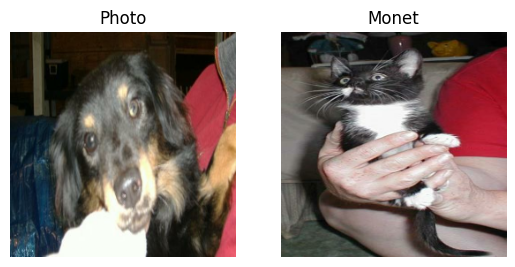

In [7]:
IMAGE_SIZE = (256, 256)


def get_tfrec_files(folder):
    """Get TFRecord files from a specified folder in the data directory."""
    files = tf.io.gfile.glob(os.path.join("data", folder, "*.tfrec"))
    print(f"{folder.capitalize()} TFRecord Files: {len(files)}")
    return files


def process_image(image_bytes):
    """Decode and preprocess an image from raw bytes."""
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image


def parse_record(record):
    """Parse a single TFRecord example."""
    features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(record, features)
    return process_image(parsed["image"])


def build_dataset(files, batch_size=16):
    """Create a batched dataset from a list of TFRecord files."""
    ds = tf.data.TFRecordDataset(files)
    ds = ds.map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size, drop_remainder=True)


monet_files = get_tfrec_files("cat-tfrec")
photo_files = get_tfrec_files("dog-tfrec")

monet_ds = build_dataset(monet_files)
photo_ds = build_dataset(photo_files)

monet_sample = next(iter(monet_ds))[0]
photo_sample = next(iter(photo_ds))[0]

plt.subplot(121)
plt.title("Photo")
plt.axis("off")
plt.imshow(photo_sample * 0.5 + 0.5)

plt.subplot(122)
plt.title("Monet")
plt.axis("off")
plt.imshow(monet_sample * 0.5 + 0.5)
plt.show()

# Show sample images from each dataset


2025-03-01 15:22:15.353796: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-01 15:22:15.400848: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


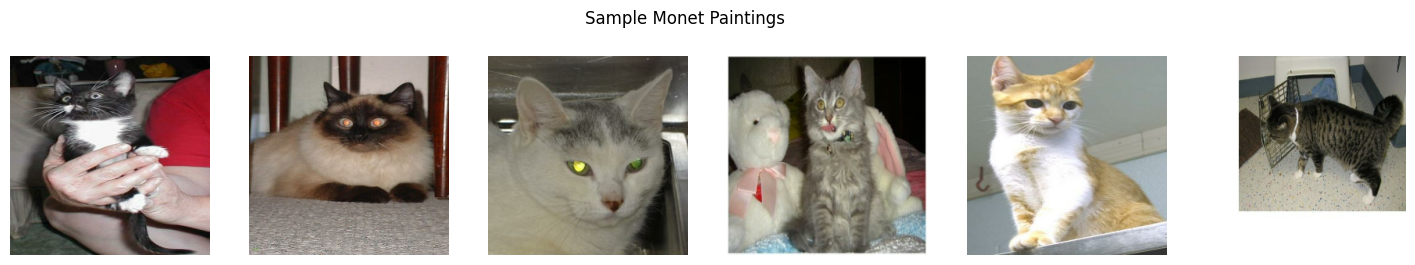

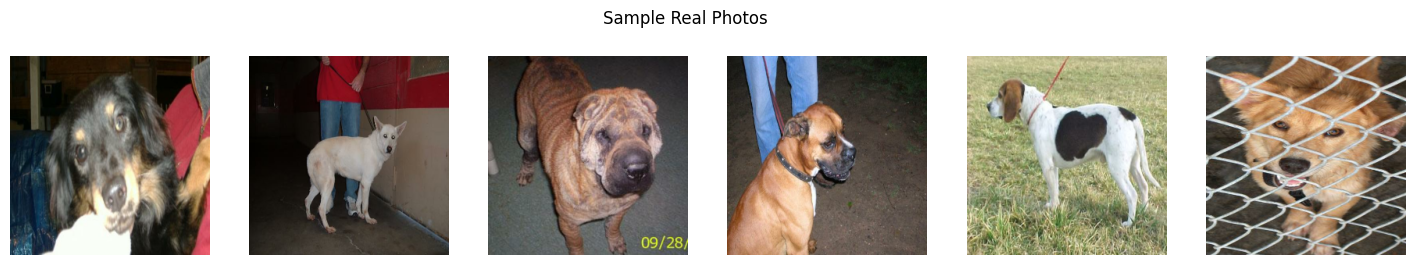

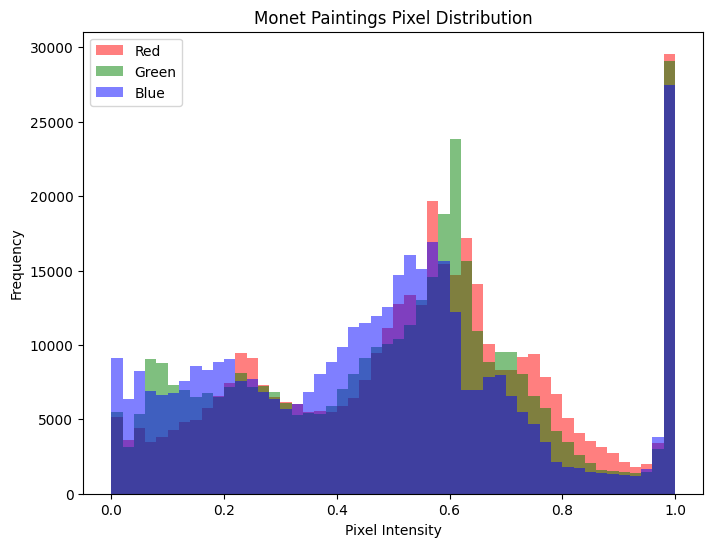

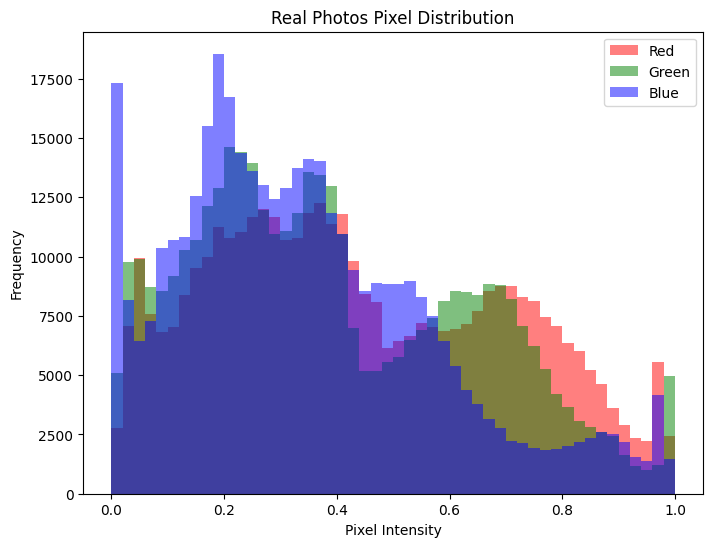

In [8]:
# Function to get a batch of images from a dataset
def get_sample_images(dataset, num_images=9):
    images = []
    for image in dataset.take(num_images):
        images.append(image[0].numpy())
    return np.array(images)


# Function to plot a grid of images
def plot_image_grid(images, title, grid_shape=(1, 6)):
    fig, axes = plt.subplots(
        grid_shape[0], grid_shape[1], figsize=(grid_shape[1] * 3, grid_shape[0] * 3)
    )
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < images.shape[0]:
            # Convert pixel range from [-1,1] to [0,1] for display
            ax.imshow(images[i] * 0.5 + 0.5)
        ax.axis("off")
    plt.show()


# Function to plot per-channel histograms
def plot_channel_histograms(images, title):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    channels = ["Red", "Green", "Blue"]
    colors = ["r", "g", "b"]

    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        channel_data = images[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.5, color=color, label=channels[i])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Function to compute and print mean and standard deviation
def compute_stats(images):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std


# Get sample images from each dataset
sample_monets = get_sample_images(monet_ds, num_images=6)
sample_photos = get_sample_images(photo_ds, num_images=6)

# Plot image grids
plot_image_grid(sample_monets, "Sample Monet Paintings")
plot_image_grid(sample_photos, "Sample Real Photos")

# Plot channel histograms
plot_channel_histograms(sample_monets, "Monet Paintings Pixel Distribution")
plot_channel_histograms(sample_photos, "Real Photos Pixel Distribution")

# EDA


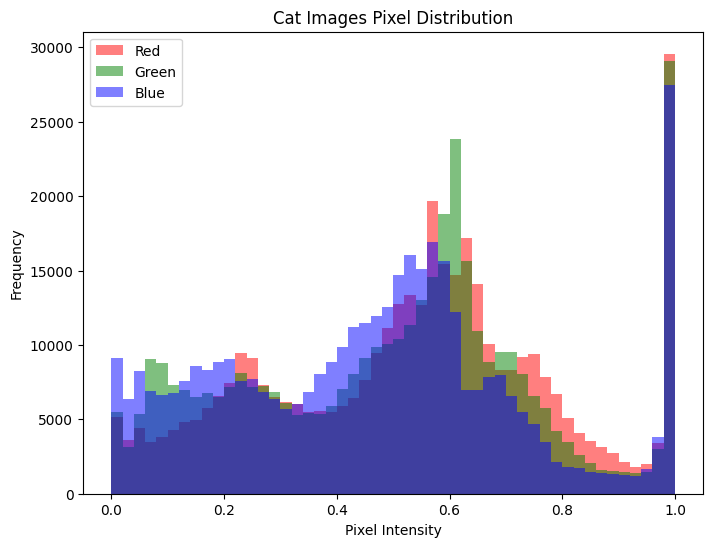

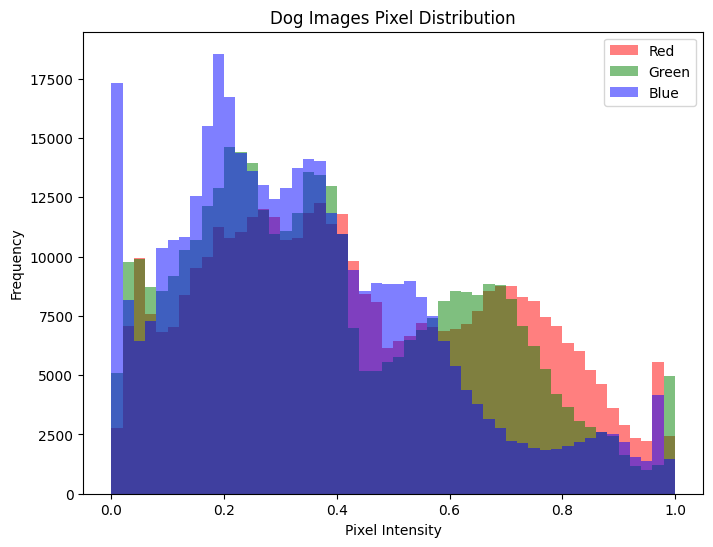

In [9]:
# Function to plot per-channel histograms
def plot_channel_histograms(images, title):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    channels = ["Red", "Green", "Blue"]
    colors = ["r", "g", "b"]

    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        channel_data = images[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.5, color=color, label=channels[i])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Function to compute and print mean and standard deviation
def compute_stats(images):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std


# Plot channel histograms
plot_channel_histograms(sample_monets, "Cat Images Pixel Distribution")
plot_channel_histograms(sample_photos, "Dog Images Pixel Distribution")

Cat JPG Files: 12405
Dog JPG Files: 12364


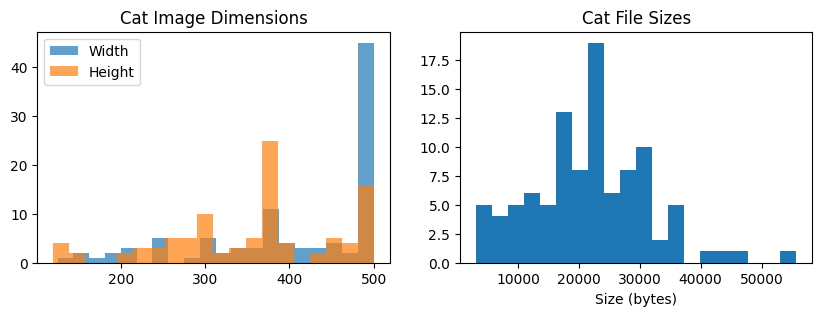

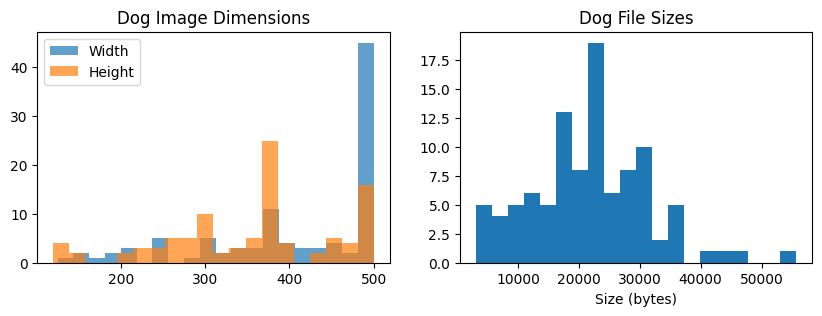

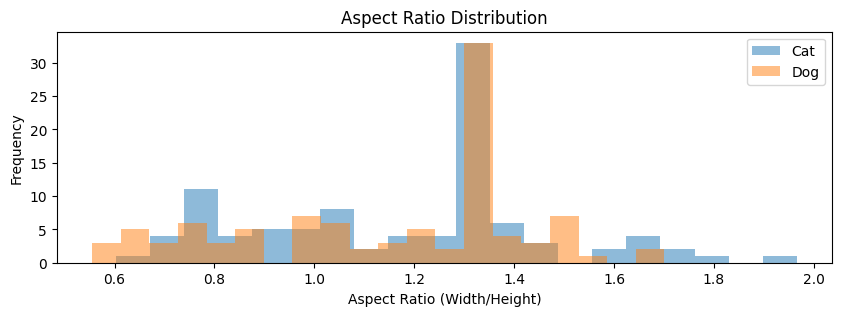

In [10]:
def get_jpg_files(folder):
    """Get JPG files from a specified folder in the data directory."""
    files = tf.io.gfile.glob(os.path.join("data", folder, "*.jpg"))
    print(f"{folder.capitalize()} JPG Files: {len(files)}")
    return files

def dataset_summary(files, folder):
    image_sizes = []
    file_sizes = []

    for file in files[:100]:  # Sample for speed
        with Image.open(file) as img:
            image_sizes.append(img.size)
            file_sizes.append(os.path.getsize(file))

    # Plot image dimension distributions and file size distribution
    widths, heights = zip(*image_sizes)
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].hist(widths, bins=20, alpha=0.7, label="Width")
    axes[0].hist(heights, bins=20, alpha=0.7, label="Height")
    axes[0].legend()
    axes[0].set_title(f"{folder} Image Dimensions")

    axes[1].hist(file_sizes, bins=20)
    axes[1].set_title(f"{folder} File Sizes")
    axes[1].set_xlabel("Size (bytes)")
    plt.show()

cat_jpg_files = get_jpg_files("Cat")
dog_jpg_files = get_jpg_files("Dog")

dataset_summary(cat_jpg_files, "Cat")
dataset_summary(cat_jpg_files, "Dog")


def aspect_ratio_analysis(files, folder):
    ratios = []
    for file in files[:100]:
        with Image.open(file) as img:
            width, height = img.size
            ratios.append(width / height)
    return ratios


cat_ratios = aspect_ratio_analysis(cat_jpg_files, "Cat")
dog_ratios = aspect_ratio_analysis(dog_jpg_files, "Dog")

plt.figure(figsize=(10, 3))
plt.hist(cat_ratios, bins=20, alpha=0.5, label="Cat")
plt.hist(dog_ratios, bins=20, alpha=0.5, label="Dog")
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# CycleGAN

## Generator

## Discriminator

## Loss functions

In [11]:
class Downsample(layers.Layer):
    def __init__(self, filters, size, apply_instancenorm=True, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False,
        )
        self.norm = (
            tf.keras.layers.GroupNormalization(
                gamma_initializer=keras.initializers.RandomNormal(
                    mean=0.0, stddev=0.02
                ),
                groups=-1,
            )
            if apply_instancenorm
            else None
        )
        self.activation = layers.LeakyReLU()

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        if self.norm:
            x = self.norm(x)
        return self.activation(x)


class Upsample(layers.Layer):
    def __init__(self, filters, size, apply_dropout=False, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False,
        )
        self.norm = tf.keras.layers.GroupNormalization(
            gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
            groups=-1,
        )
        self.dropout = layers.Dropout(0.5) if apply_dropout else None
        self.activation = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.conv_transpose(inputs)
        x = self.norm(x)
        if self.dropout:
            x = self.dropout(x, training=training)
        return self.activation(x)


class Generator(keras.Model):
    def __init__(self, output_channels=3, **kwargs):
        super().__init__(**kwargs)
        self.down_stack = [
            Downsample(64, 4, apply_instancenorm=False),
            Downsample(128, 4),
            Downsample(256, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
        ]

        self.up_stack = [
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4),
            Upsample(256, 4),
            Upsample(128, 4),
            Upsample(64, 4),
        ]

        self.last_conv = layers.Conv2DTranspose(
            output_channels,
            4,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation="tanh",
        )
        self.concat = layers.Concatenate()

    def call(self, inputs, training=False):
        x = inputs
        skips = []
        for down in self.down_stack:
            x = down(x, training=training)
            skips.append(x)
        # Remove the bottleneck output and reverse the skip connections
        skips = list(reversed(skips[:-1]))
        for up, skip in zip(self.up_stack, skips):
            x = up(x, training=training)
            x = self.concat([x, skip])
        return self.last_conv(x)

In [12]:
class Discriminator(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        initializer = tf.random_normal_initializer(0.0, 0.02)
        gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        self.down1 = Downsample(64, 4, apply_instancenorm=False)
        self.down2 = Downsample(128, 4)
        self.down3 = Downsample(256, 4)
        self.zero_pad1 = layers.ZeroPadding2D()
        self.conv = layers.Conv2D(
            512, 4, strides=1, kernel_initializer=initializer, use_bias=False
        )
        self.norm1 = layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1)
        self.leaky_relu = layers.LeakyReLU()
        self.zero_pad2 = layers.ZeroPadding2D()
        self.last_conv = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)

    def call(self, inputs, training=False):
        x = self.down1(inputs, training=training)
        x = self.down2(x, training=training)
        x = self.down3(x, training=training)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.norm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.last_conv(x)


with strategy.scope():
    monet_generator = Generator()  # transforms photos to Monet-esque paintings
    photo_generator = Generator()  # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator()  # differentiates real vs. generated Monet
    photo_discriminator = Discriminator()  # differentiates real vs. generated photos

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self, monet_gen, photo_gen, monet_disc, photo_disc, lambda_cycle=10, **kwargs
    ):
        super().__init__(**kwargs)
        self.m_gen = monet_gen
        self.p_gen = photo_gen
        self.m_disc = monet_disc
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        **kwargs
    ):
        super().compile(**kwargs)
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def compute_losses(self, real_monet, real_photo):
        # Generate fake images and their cycles
        fake_monet = self.m_gen(real_photo, training=True)
        cycled_photo = self.p_gen(fake_monet, training=True)
        fake_photo = self.p_gen(real_monet, training=True)
        cycled_monet = self.m_gen(fake_photo, training=True)

        # Identity mappings
        same_monet = self.m_gen(real_monet, training=True)
        same_photo = self.p_gen(real_photo, training=True)

        # Discriminator evaluations
        disc_real_monet = self.m_disc(real_monet, training=True)
        disc_fake_monet = self.m_disc(fake_monet, training=True)
        disc_real_photo = self.p_disc(real_photo, training=True)
        disc_fake_photo = self.p_disc(fake_photo, training=True)

        # Generator losses
        monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
        photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

        cycle_loss = self.cycle_loss_fn(
            real_monet, cycled_monet, self.lambda_cycle
        ) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

        id_loss_monet = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
        id_loss_photo = self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

        total_monet_gen_loss = monet_gen_loss + cycle_loss + id_loss_monet
        total_photo_gen_loss = photo_gen_loss + cycle_loss + id_loss_photo

        # Discriminator losses
        monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
        photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        return {
            "total_monet_gen_loss": total_monet_gen_loss,
            "total_photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
        }

    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            losses = self.compute_losses(real_monet, real_photo)

        # Compute gradients for generators
        m_gen_grads = tape.gradient(
            losses["total_monet_gen_loss"], self.m_gen.trainable_variables
        )
        p_gen_grads = tape.gradient(
            losses["total_photo_gen_loss"], self.p_gen.trainable_variables
        )
        # Compute gradients for discriminators
        m_disc_grads = tape.gradient(
            losses["monet_disc_loss"], self.m_disc.trainable_variables
        )
        p_disc_grads = tape.gradient(
            losses["photo_disc_loss"], self.p_disc.trainable_variables
        )

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(
            zip(m_gen_grads, self.m_gen.trainable_variables)
        )
        self.p_gen_optimizer.apply_gradients(
            zip(p_gen_grads, self.p_gen.trainable_variables)
        )
        self.m_disc_optimizer.apply_gradients(
            zip(m_disc_grads, self.m_disc.trainable_variables)
        )
        self.p_disc_optimizer.apply_gradients(
            zip(p_disc_grads, self.p_disc.trainable_variables)
        )

        return {
            "monet_gen_loss": losses["total_monet_gen_loss"],
            "photo_gen_loss": losses["total_photo_gen_loss"],
            "monet_disc_loss": losses["monet_disc_loss"],
            "photo_disc_loss": losses["photo_disc_loss"],
        }

In [14]:
class CycleGanLosses:
    @staticmethod
    def discriminator_loss(real, generated):
        bce = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        real_loss = bce(tf.ones_like(real), real)
        generated_loss = bce(tf.zeros_like(generated), generated)
        return 0.5 * (real_loss + generated_loss)

    @staticmethod
    def generator_loss(generated):
        bce = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        return bce(tf.ones_like(generated), generated)

    @staticmethod
    def cycle_loss(real_image, cycled_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return lambda_cycle * loss

    @staticmethod
    def identity_loss(real_image, same_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_cycle * 0.5 * loss

In [15]:
with strategy.scope():
    # Configure optimizers with shared settings
    optimizer_config = {"learning_rate": 2e-4, "beta_1": 0.5}
    monet_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    photo_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)

    # Instantiate and compile the CycleGAN model using the new loss functions
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer=monet_generator_optimizer,
        p_gen_optimizer=photo_generator_optimizer,
        m_disc_optimizer=monet_discriminator_optimizer,
        p_disc_optimizer=photo_discriminator_optimizer,
        gen_loss_fn=CycleGanLosses.generator_loss,
        disc_loss_fn=CycleGanLosses.discriminator_loss,
        cycle_loss_fn=CycleGanLosses.cycle_loss,
        identity_loss_fn=CycleGanLosses.identity_loss,
    )

cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=1)

I0000 00:00:1740867761.108697   43552 service.cc:148] XLA service 0x7f57b801ad70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740867761.108745   43552 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-01 15:22:42.247040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740867764.257434   43552 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1740867794.225516   43552 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


772/772 ━━━━━━━━━━━━━━━━━━━━ 346s 375ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 3.6010 - photo_disc_loss: 0.5678 - photo_gen_loss: 3.7972


2025-03-01 15:28:03.518760: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/david/catdog-image-translation/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


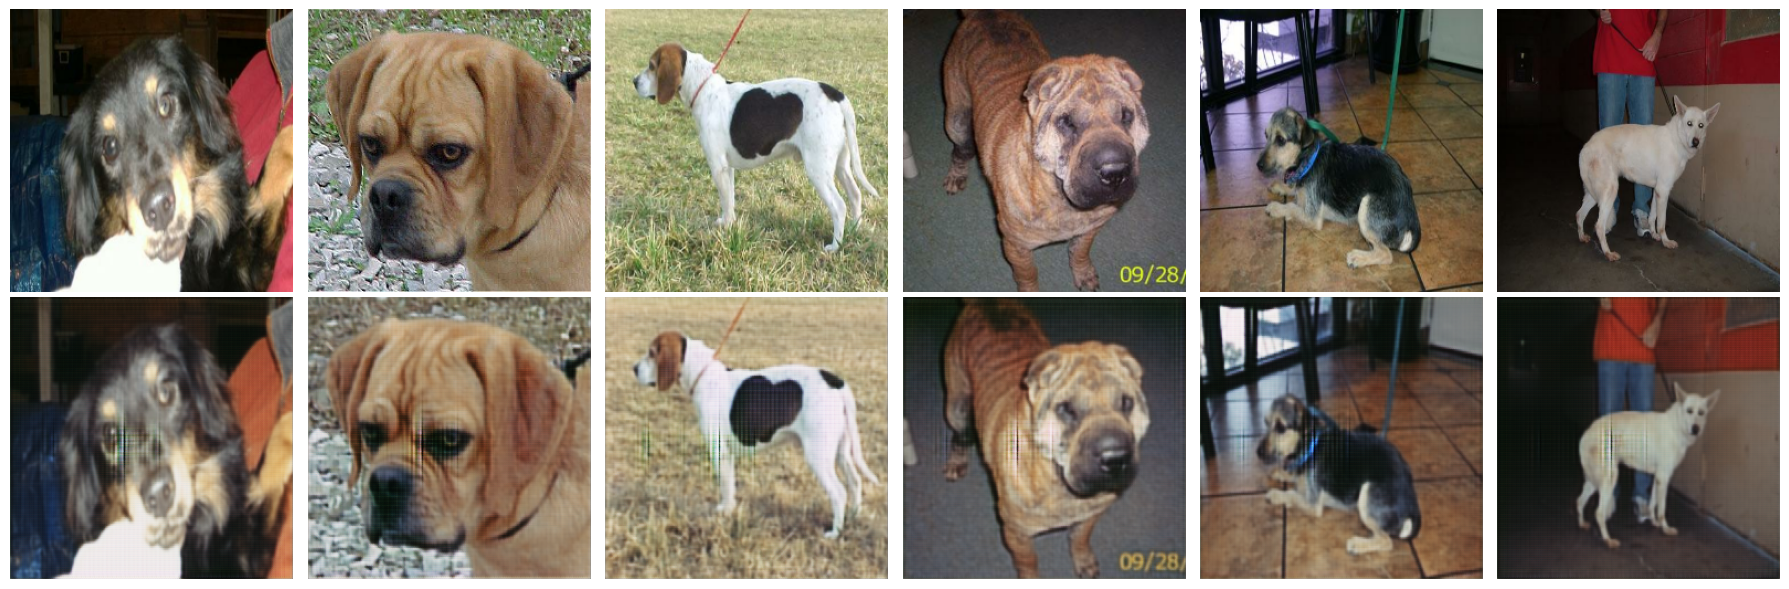

In [16]:
fig, ax = plt.subplots(2, 6, figsize=(18, 6))
for i, img in enumerate(photo_ds.shuffle(10).take(6)):
    original = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    transformed = monet_generator(img, training=False)[0].numpy()
    transformed = (transformed * 127.5 + 127.5).astype(np.uint8)

    ax[0, i].imshow(original)
    ax[0, i].axis("off")
    ax[1, i].imshow(transformed)
    ax[1, i].axis("off")

ax[0, 0].set_ylabel("Input Photos", fontsize=14)
ax[1, 0].set_ylabel("Monet Transformations", fontsize=14)
plt.tight_layout()
plt.show()